# FGPA vs Hydro

In this notebook, we compare the FGPA applied on DM-only TNG300-1 with TNG300-1 hydro simulations. 

Literature works :

- FGPA  : 

[Sorini 2016](https://iopscience.iop.org/article/10.3847/0004-637X/827/2/97/pdf)

[Kulkarni 2015](https://iopscience.iop.org/article/10.1088/0004-637X/812/1/30/pdf)

- Feedbacks and Ly$\alpha$ Forest:

[Nagamine](https://arxiv.org/pdf/2007.14253.pdf)

[Viel 2012](https://arxiv.org/pdf/1207.6567.pdf)

May not be relevant [Sorini 2020](https://arxiv.org/pdf/2005.08971.pdf)

[Simeon's BAHAMAS Project](https://arxiv.org/abs/1603.02702)

The Volume ratio of TNG300/LATIS :

In [1]:
(63*51*483)/(205**3)

0.1801342406523411

## Generating spectra :

### Steps:

1. CIC-bin the density map
  
  Following the tradition of 1 particle per cell, we have $2500^3$ cells.
  
2. Apply FGPA to get $\tau_{real}$

   1. Smooth density with($\lambda_G$ and velocity with $\lambda_v$
   
     Drew did not smooth the DM for N-body planck with $\sim 228 ckpc$ spatial resolution.
   
   2. Calculate Temperature $T = T_0 (1 + \delta_b)^{\gamma - 1 }$
   
   3. Calculate $ n_{HI} \propto (1+\delta_b)^{2-0.7(\gamma -1)}$
   
   4. $\tau_{real} (u) = \frac{\lambda_{Ly\alpha} \sigma}{H(z)}n_{HI}(u)$
   
      

3. Convolution with Gasussian approximation of the Voight profile

    - The intergral's limits ? Along the whole line of sight ? Yes
    - Just generate the mesh in real space with $\sim 2500^3$ grids. Also save the $v_{pec}$ of each voxel. Then
      cacluate the convolution below :
    
        $\tau(u) = \frac{\lambda_{Ly\alpha} \sigma}{H(z)} \int du^{\prime} \frac{n_{HI}(u^{\prime})}{b(u^{\prime})} exp[-(\frac{ (u - u^{\prime} - u_{pec})}{b(u^{\prime})})^2]$
         
        - This kernel is not constant for all pixel along the los. So, we calculate convolution manually. 
        
        - Periodc boundary should be applied 


4. Fix the amplitude with mean flux or 1D power. 

5. Resampling the pixels to larger sizes : By averaging the flux within each larger pixel


### Test :

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('Notebook.mystyle')
from astropy.cosmology import Planck15 as cosmo
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d

### $\tau_{real}$ vs $\tau_{conv}$

2.4442257045541464
2460


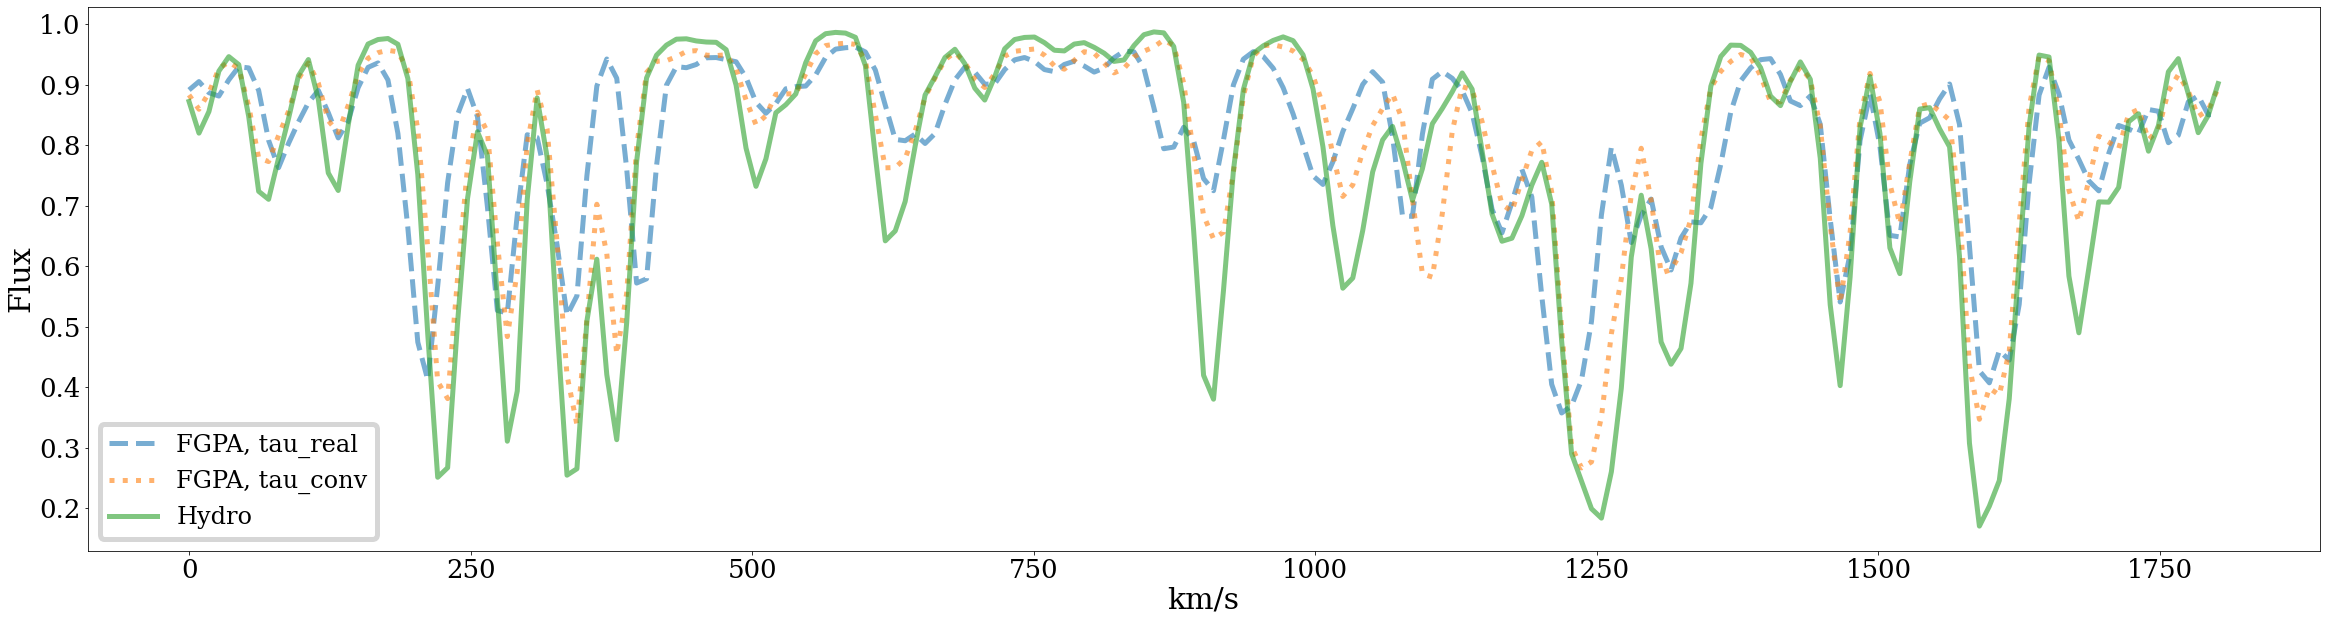

In [2]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
import FGPA.FGPA_parallel as fgpa
importlib.reload(fgpa)
def compare_real_conv():
    plt.figure(figsize=(40,10))
    z, boxsize, pix = 2.4442257045541464, 205, 12
    with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('./FGPA/0_densfield.hdf5','r') as f:
        Nx, Ny, Nz = f['DM/dens'][:].shape[0], f['DM/dens'][:].shape[1], f['DM/dens'][:].shape[2]
        print(Nz)
        dvbin = cosmo.H(z).value*boxsize/(cosmo.h*Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(60,60)] :
            dens = f['DM/dens'][i,j,:]
            ind = np.where(dens != 0)
            vel_pec = np.zeros_like(f['DM/Vz'][i,j,:])
            vel_pec[ind] = f['DM/Vz'][i,j,:][ind]/(dens[ind]*np.sqrt(1+z))
            vel_pec = gaussian_filter1d(vel_pec, 3)
            dens = gaussian_filter1d(dens,3)
            u0 = up + vel_pec

            tau_real = fgpa.get_tau_real(dens, z=z)
            tau_conv = np.empty_like(tau_real)
            btherm = fgpa.get_btherm(dens)
            # To avoide devision by 0, if b_threm == 0, pass a nonzero value since
            # tau_real is 0 in that voxel anyway; therefore tau_conv will be 0.
            btherm[np.where(btherm==0)] = 1
            
            for k in range(Nz) :
                # With periodic BC
                dvel = np.abs(up[k]-u0)
                indv = np.where(dvel > dvbin*Nz/2)
                dvel[indv] = dvbin*Nz - dvel[indv]
                Voight = (1/btherm)*np.exp(-(dvel/btherm)**2)
                tau_conv[k] = np.sum(tau_real*Voight*dvbin)
            scale = fs.mean_flux(tau_real, mean_flux_desired=0.8030459657915272)
            flux_real = np.array([np.sum(np.exp(-scale*tau_real[t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            scale = fs.mean_flux(tau_conv, mean_flux_desired=0.8030459657915272)
            flux_conv = np.array([np.sum(np.exp(-scale*tau_conv[t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            flux_real = gaussian_filter1d(flux_real, sigma=1, mode='wrap')
            flux_conv = gaussian_filter1d(flux_conv, sigma=1, mode='wrap')
            plt.plot(np.arange(flux_real.shape[0])*dvbin,flux_real, label='FGPA, tau_real', alpha=0.6, ls='--')
            plt.plot(np.arange(flux_conv.shape[0])*dvbin,flux_conv, label='FGPA, tau_conv', alpha=0.6, ls='dotted')
            
        flux_hydro = gaussian_filter1d(true_map[5,5,:], sigma=1, mode='wrap')
        plt.plot(np.arange(flux_hydro.shape[0])*dvbin, flux_hydro, label='Hydro', alpha=0.6)
        
        plt.legend()
        plt.xlabel('km/s')
        plt.ylabel('Flux')
            
compare_real_conv()

### $b_{therm}$ 's effect :

2.4442257045541464


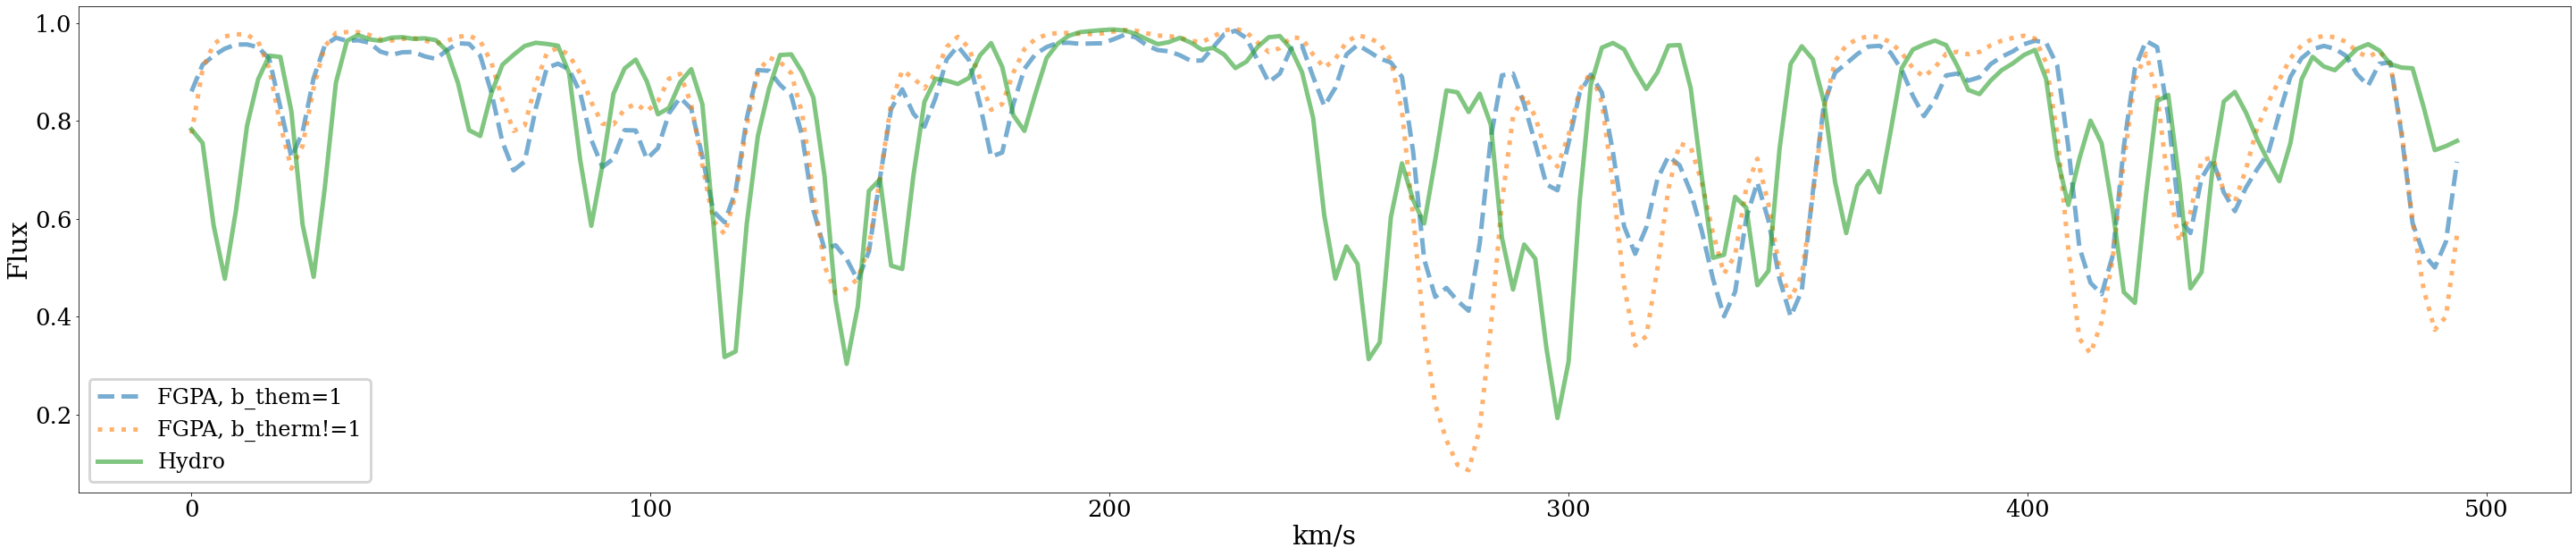

In [89]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
importlib.reload(fgpa)
def check_btherm():
    plt.figure(figsize=(50,10))
    z, boxsize, pix = 2.4442257045541464, 205, 12
    with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('./FGPA/0_densfield.hdf5','r') as f:
        Nx, Ny, Nz = f['DM/dens'][:].shape[0], f['DM/dens'][:].shape[1], f['DM/dens'][:].shape[2]
        dvbin = 100*boxsize/(Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(120,120)] :
            ind = np.where((f['DM/dens'][i,j,:] != 0))
            vel_pec = np.zeros_like(f['DM/Vz'][i,j,:])
            vel_pec[ind] = f['DM/Vz'][i,j,:][ind]/(f['DM/dens'][i,j,:][ind]*np.sqrt((1+z)))
            vel_pec = gaussian_filter1d(vel_pec, 3)
            u0 = up + vel_pec

            tau_real = fgpa.get_tau_real(f['DM/dens'][:], z=z)
            tau_b = np.empty_like(tau_real)
            tau_b1 = np.empty_like(tau_real)
            btherm = fgpa.get_btherm(f['DM/dens'][i,j,:])
            # To avoide devision by 0, if b_threm == 0, pass a nonzero value since
            # tau_real is 0 in that voxel anyway; therefore tau_conv will be 0.
            btherm[np.where(btherm==0)] = 1.0

            for k in range(Nz) :
                # With periodic BC
                dvel = np.abs(up[k]-u0)
                indv = np.where(dvel > dvbin*Nz/2)
                dvel[indv] = dvbin*Nz - dvel[indv]
                Voight = (1/btherm)*np.exp(-(dvel/btherm)**2)
                # No priodic BC
                #Voight = (1/btherm)*np.exp(-((up[k]-u0)**2/btherm**2))
                tau_b[i,j,k] = np.sum(tau_real[i,j,:]*Voight*dvbin)
            for k in range(Nz) :
                # With periodic BC
                btherm=1
                dvel = np.abs(up[k]-u0)
                indv = np.where(dvel > dvbin*Nz/2)
                dvel[indv] = dvbin*Nz - dvel[indv]
                Voight = (1/btherm)*np.exp(-(dvel/btherm)**2)
                # No priodic BC
                #Voight = (1/btherm)*np.exp(-((up[k]-u0)**2/btherm**2))
                tau_b1[i,j,k] = np.sum(tau_real[i,j,:]*Voight*dvbin)

            scale = fs.mean_flux(tau_b1[i,j,:], mean_flux_desired=0.8030459657915272)
            flux_b1 = np.array([np.sum(np.exp(-scale*tau_b1[i,j,t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            scale = fs.mean_flux(tau_b[i,j,:], mean_flux_desired=0.8030459657915272)
            flux_b = np.array([np.sum(np.exp(-scale*tau_b[i,j,t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            flux_b1 = gaussian_filter1d(flux_b1, sigma=1, mode='wrap')
            flux_b = gaussian_filter1d(flux_b, sigma=1, mode='wrap')
            
            plt.plot(np.arange(flux_b1.shape[0])*dvbin,flux_b1, label='FGPA, b_them=1', alpha=0.6, ls='--')
            plt.plot(np.arange(flux_b.shape[0])*dvbin,flux_b, label='FGPA, b_therm!=1', alpha=0.6, ls='dotted')
            
        flux_hydro = gaussian_filter1d(true_map[10,10,:], sigma=1, mode='wrap')
        plt.plot(np.arange(flux_hydro.shape[0])*dvbin, flux_hydro, label='Hydro', alpha=0.6)
        
        plt.legend()
        plt.xlabel('km/s')
        plt.ylabel('Flux')
            
check_btherm()

### Peculiar velocity :

2.4442257045541464


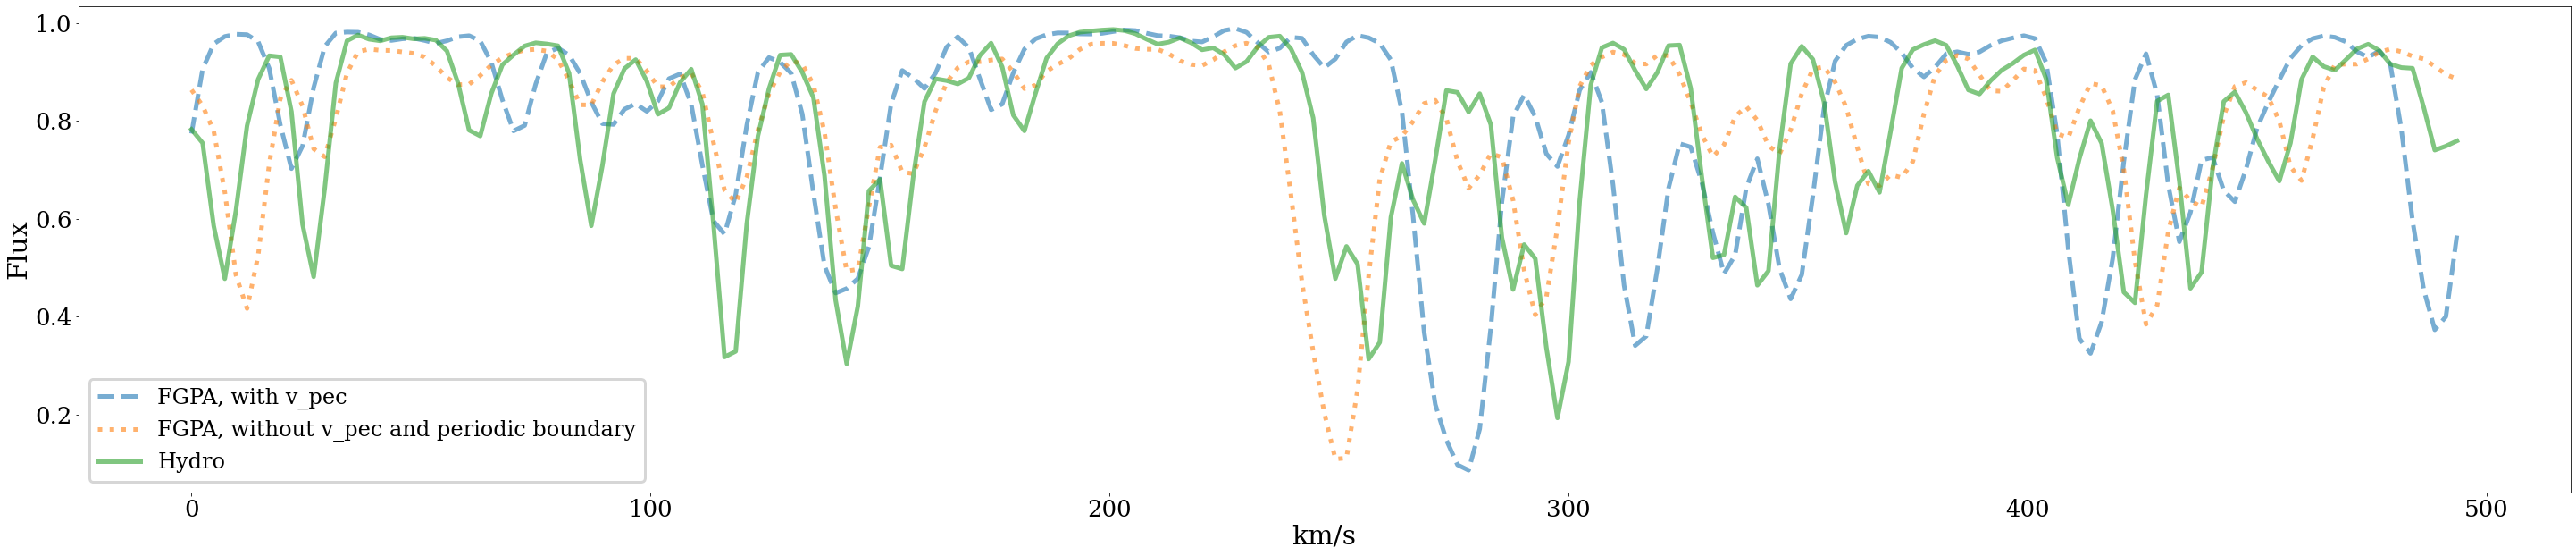

In [90]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
import FGPA.FGPA_parallel as fgpa
importlib.reload(fgpa)
def check_pec():
    plt.figure(figsize=(50,10))
    z, boxsize, pix = 2.4442257045541464, 205, 12
    with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('./FGPA/0_densfield.hdf5','r') as f:
        Nx, Ny, Nz = f['DM/dens'][:].shape[0], f['DM/dens'][:].shape[1], f['DM/dens'][:].shape[2]
        dvbin = 100*boxsize/(Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(120,120)] :
            ind = np.where((f['DM/dens'][i,j,:] != 0))
            vel_pec = np.zeros_like(f['DM/Vz'][i,j,:])
            vel_pec[ind] = f['DM/Vz'][i,j,:][ind]/(f['DM/dens'][i,j,:][ind]*np.sqrt((1+z)))
            vel_pec = gaussian_filter1d(vel_pec, 3)
            u0 = up + vel_pec
            tau_real = fgpa.get_tau_real(f['DM/dens'][:], z=z)
            tau_bc = np.empty_like(tau_real)
            tau_nbc = np.empty_like(tau_real)
            btherm = fgpa.get_btherm(f['DM/dens'][i,j,:])
            # To avoide devision by 0, if b_threm == 0, pass a nonzero value since
            # tau_real is 0 in that voxel anyway; therefore tau_conv will be 0.
            btherm[np.where(btherm==0)] = 1.0

            for k in range(Nz) :
                # With periodic BC
                dvel = np.abs(up[k]-u0)
                indv = np.where(dvel > dvbin*Nz/2)
                dvel[indv] = dvbin*Nz - dvel[indv]
                Voight = (1/btherm)*np.exp(-(dvel/btherm)**2)
                tau_bc[i,j,k] = np.sum(tau_real[i,j,:]*Voight*dvbin)
            for k in range(Nz) :
                # No priodic BC
                Voight = (1/btherm)*np.exp(-((up[k]-up)**2/btherm**2))
                tau_nbc[i,j,k] = np.sum(tau_real[i,j,:]*Voight*dvbin)

            scale = fs.mean_flux(tau_bc[i,j,:], mean_flux_desired=0.8030459657915272)
            flux_bc = np.array([np.sum(np.exp(-scale*tau_bc[i,j,t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            scale = fs.mean_flux(tau_nbc[i,j,:], mean_flux_desired=0.8030459657915272)
            flux_nbc = np.array([np.sum(np.exp(-scale*tau_nbc[i,j,t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            flux_bc = gaussian_filter1d(flux_bc, sigma=1, mode='wrap')
            flux_nbc = gaussian_filter1d(flux_nbc, sigma=1, mode='wrap')
            
            plt.plot(np.arange(flux_bc.shape[0])*dvbin,flux_bc, label='FGPA, with v_pec', alpha=0.6, ls='--')
            plt.plot(np.arange(flux_nbc.shape[0])*dvbin,flux_nbc, label='FGPA, without v_pec and periodic boundary', alpha=0.6, ls='dotted')
            
        flux_hydro = gaussian_filter1d(true_map[10,10,:], sigma=1, mode='wrap')
        plt.plot(np.arange(flux_hydro.shape[0])*dvbin, flux_hydro, label='Hydro', alpha=0.6)
        
        plt.legend()
        plt.xlabel('km/s')
        plt.ylabel('Flux')
            
            
check_pec()

### Check fields one by one :

In [15]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
import FGPA.FGPA_parallel as fgpa
importlib.reload(fgpa)
def check_velocity(ax):
    plt.figure(figsize=(40,15))
    z, boxsize, pix = 2.4442257045541464, 205, 12
    with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('./FGPA/0_densfield.hdf5','r') as f:
        Nx, Ny, Nz = f['DM/dens'][:].shape[0], f['DM/dens'][:].shape[1], f['DM/dens'][:].shape[2]
        dvbin = 100*boxsize/(Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(120,120)] :
            ind = np.where((f['DM/dens'][i,j,:] != 0))
            vel_pec = np.zeros_like(f['DM/Vz'][i,j,:])
            vel_pec[ind] = f['DM/Vz'][i,j,:][ind]/(f['DM/dens'][i,j,:][ind]*np.sqrt((1+z)))
            vel_pec = gaussian_filter1d(vel_pec, 3)
            ax.plot(np.arange(vel_pec.size)*dvbin, vel_pec, label='DM V_pec')
            
            ind = np.where((f['Gas/dens'][i,j,:] != 0))
            vel_pec = np.zeros_like(f['Gas/Vz'][i,j,:])
            vel_pec[ind] = f['Gas/Vz'][i,j,:][ind]/(f['Gas/dens'][i,j,:][ind]*np.sqrt((1+z)))
            vel_pec = gaussian_filter1d(vel_pec, 3)
            ax.plot(np.arange(vel_pec.size)*dvbin,vel_pec, label='Gas V_pec', ls='dotted')

            
        ax.legend()
        ax.set_xlabel('pixel')
        ax.set_ylabel('km/s')
        ax.set_title('smoothed with '+r'$\sigma = 3$'+' pixel'+r'$ \sim 6 \ km/s$')

In [18]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
import FGPA.FGPA_parallel as fgpa
importlib.reload(fgpa)
def check_density(ax):
    z, boxsize, pix = 2.4442257045541464, 205, 12
    with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('./FGPA/0_densfield.hdf5','r') as f:
        Nx, Ny, Nz = f['DM/dens'][:].shape[0], f['DM/dens'][:].shape[1], f['DM/dens'][:].shape[2]
        dvbin = 100*boxsize/(Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(120,120)] :
            dens = f['DM/dens'][i,j,:]
            dens = gaussian_filter1d(dens, 3)
            ax.plot(np.arange(dens.size)*dvbin, dens, label='DM')
            
            dens = f['Gas/dens'][i,j,:]
            dens = gaussian_filter1d(dens, 3)
            ax.plot(np.arange(dens.size)*dvbin, dens, label='Gas', ls='dotted')
            
            
        ax.legend()
        ax.set_xlabel('pixel')
        ax.set_ylabel(r'$(1 + \delta)$')
        ax.set_title('smoothed with '+r'$\sigma = 3$'+' pixel'+r'$ \sim 6 \ km/s$')
        ax.set_yscale('log')

In [69]:
def bthermal():
    plt.figure(figsize=(40,15))
    z, boxsize, pix = 2.4442257045541464, 205, 12
    with h5py.File('./FGPA/0_densfield.hdf5','r') as f:
        btherm = fgpa.get_btherm(f['DM/dens'][120,120,:])
    plt.plot(btherm)

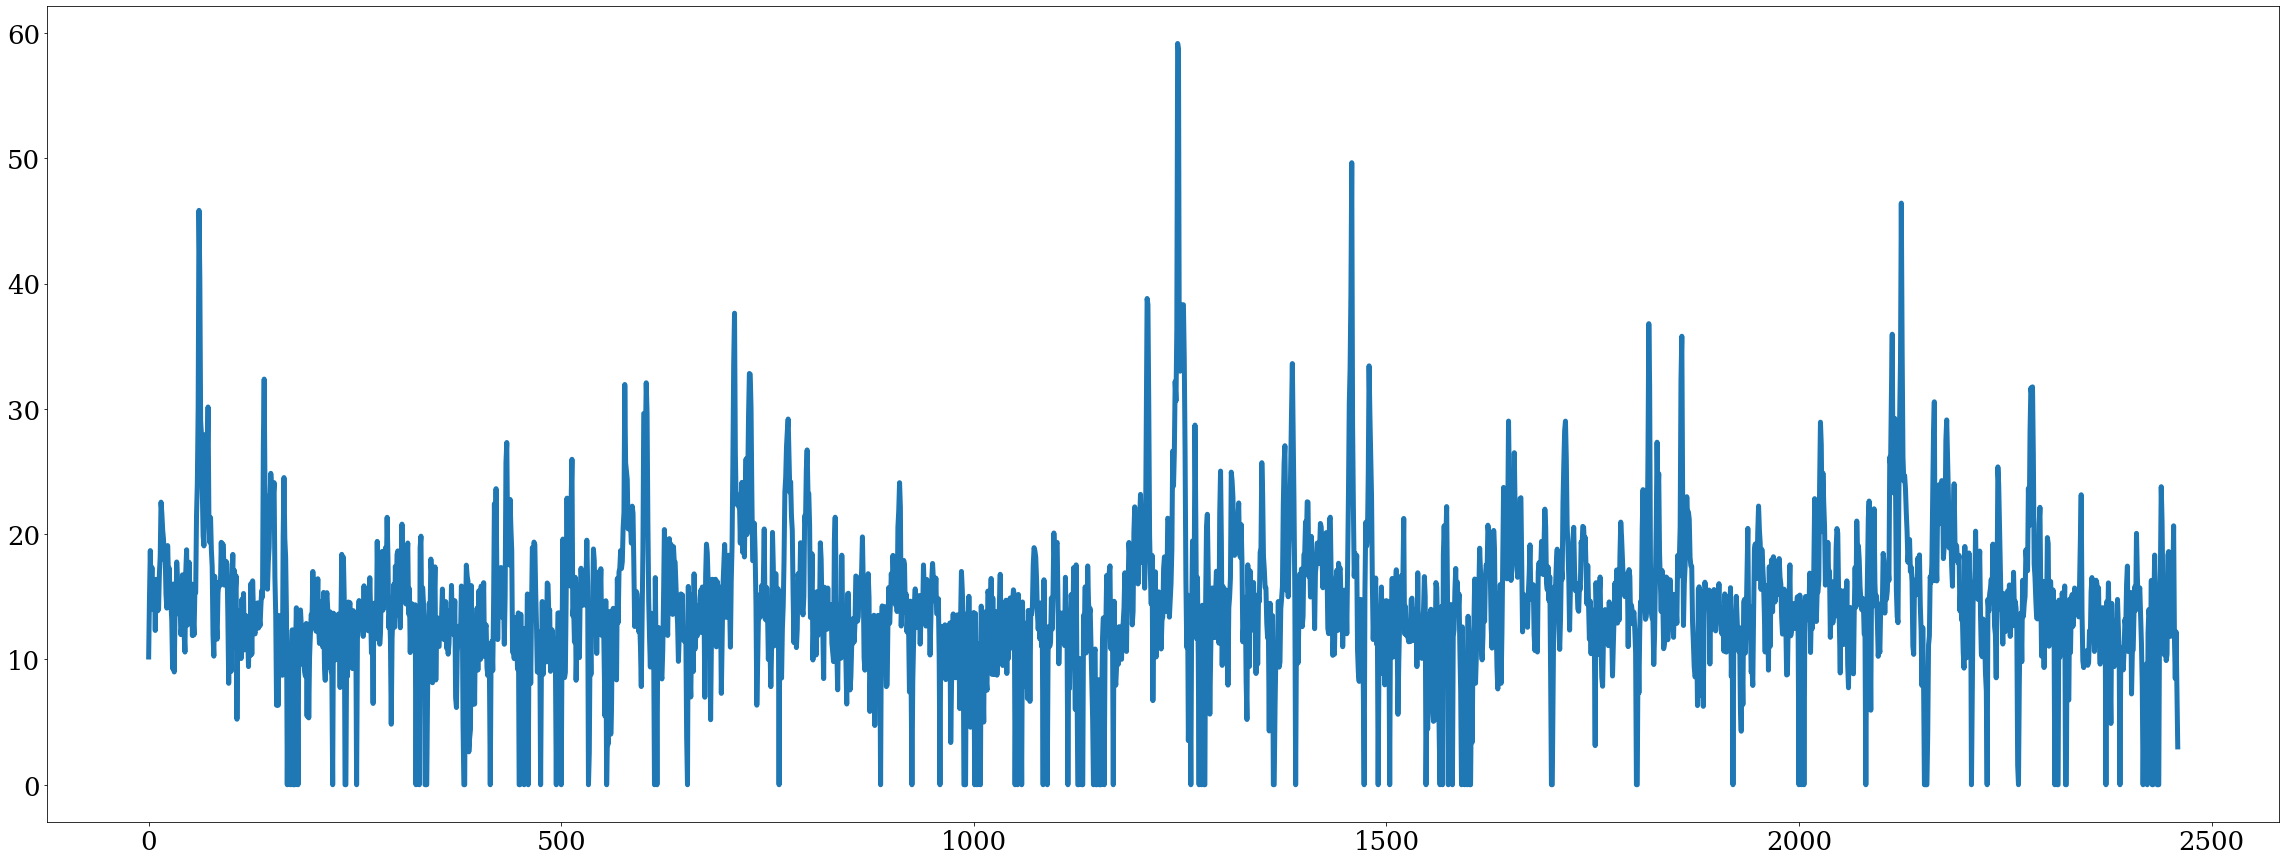

In [68]:
bthermal()

### Optimal smoothing scales :

2.4442257045541464
2460
2.4442257045541464
2460
2.4442257045541464
2460
2.4442257045541464
2460


Text(0.5, 0, 'km/s')

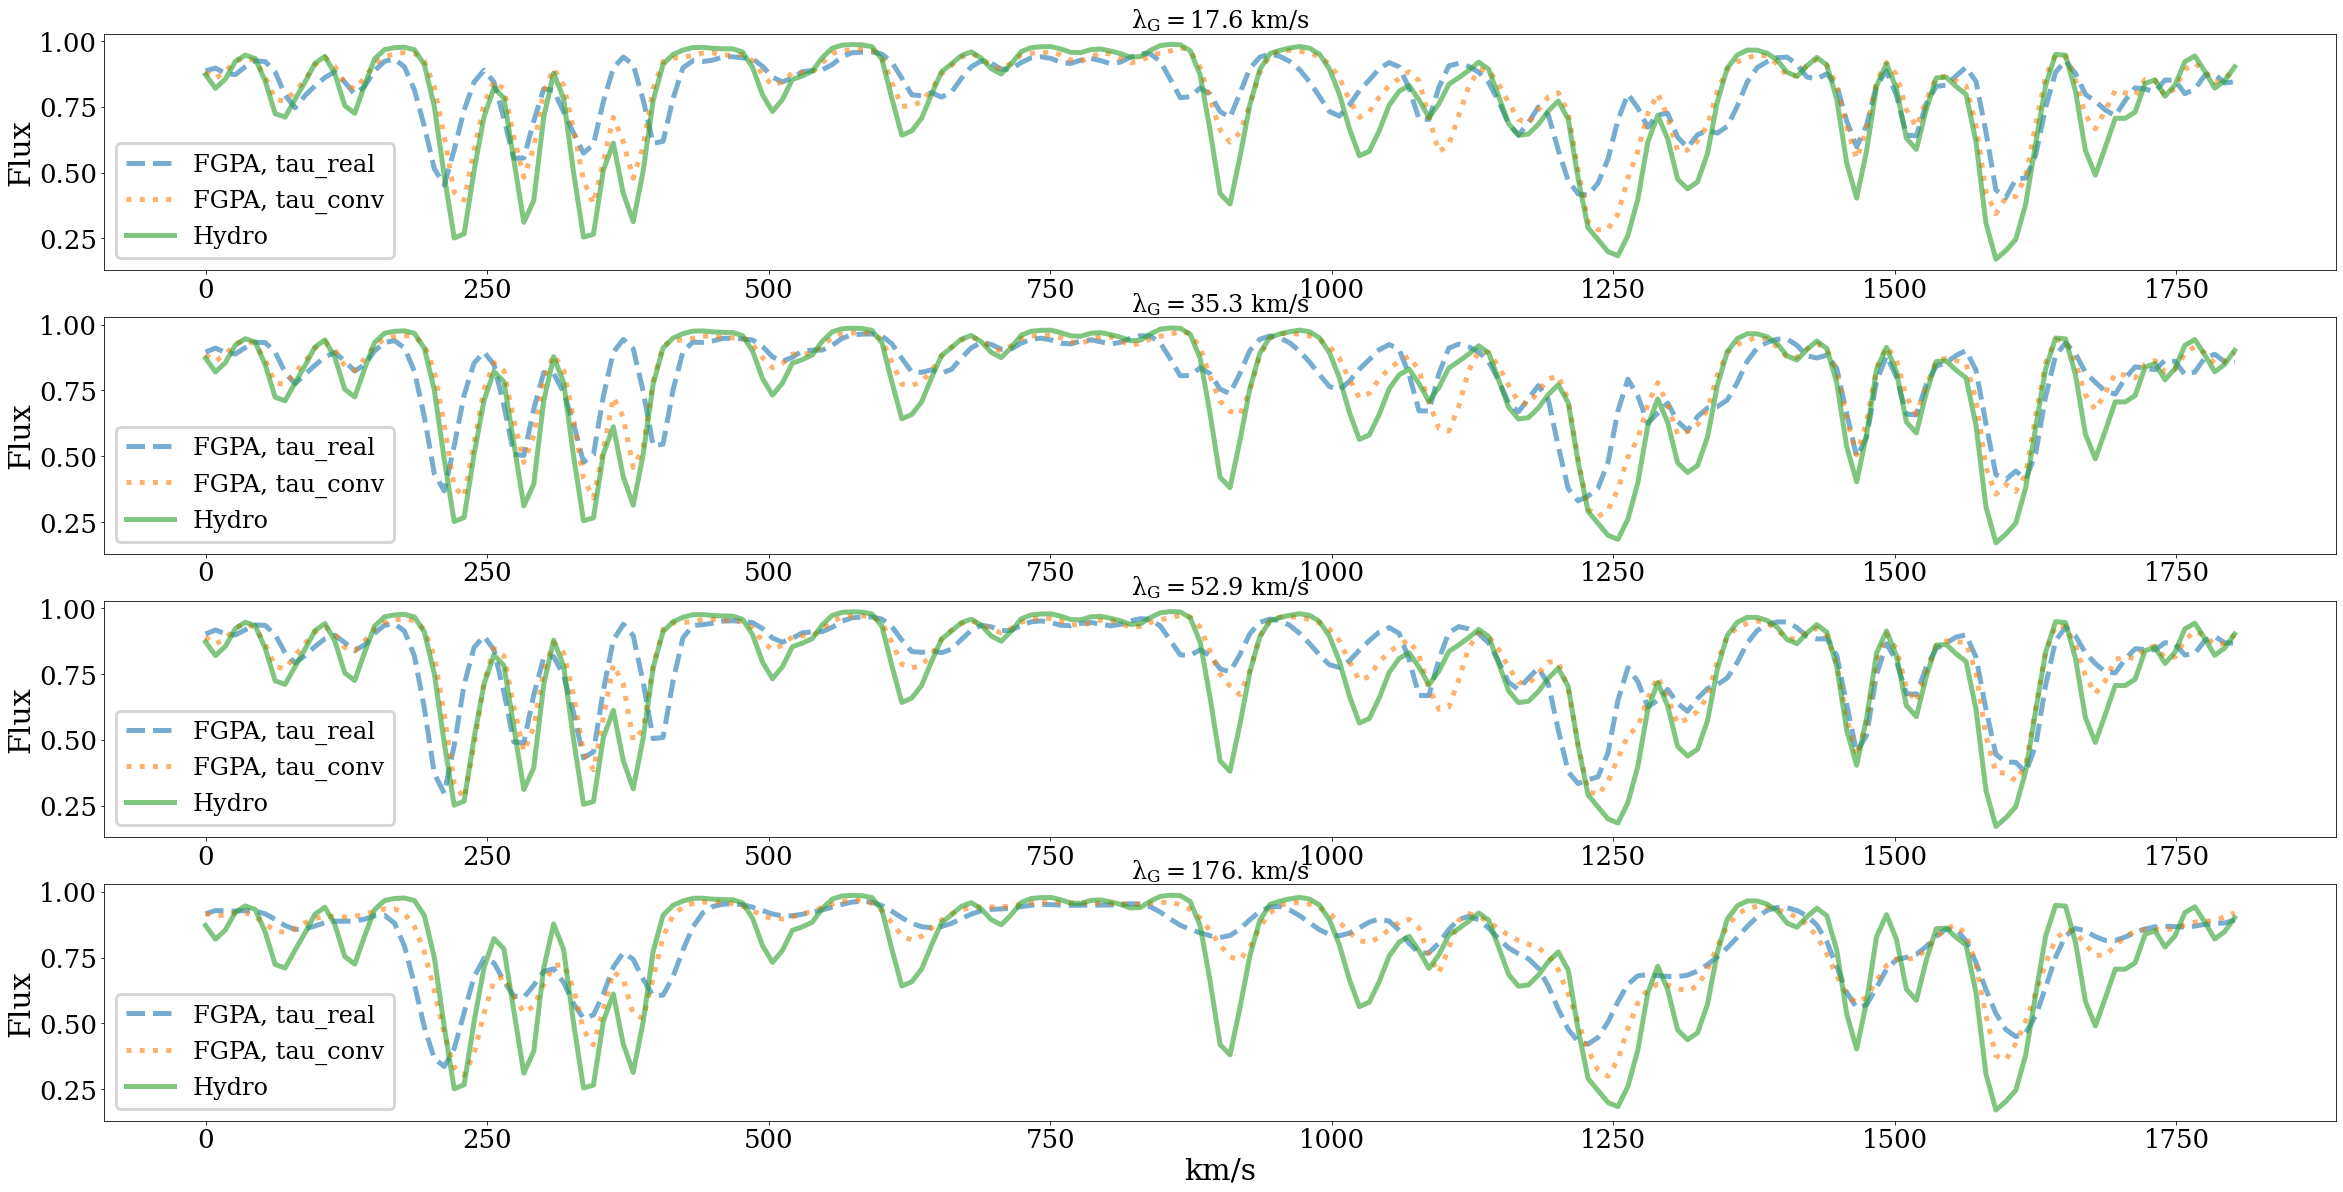

In [118]:
import importlib
from scipy.ndimage import gaussian_filter1d
import fake_spectra.fluxstatistics as fs
importlib.reload(fgpa)
def compare_real_conv(ax, lambda_G):
    z, boxsize, pix = 2.4442257045541464, 205, 12 
    with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
        print(ftrue['redshift'][()])
        true_map = ftrue['flux'][:]
    with h5py.File('./FGPA/0_densfield.hdf5','r') as f:
        Nx, Ny, Nz = f['DM/dens'][:].shape[0], f['DM/dens'][:].shape[1], f['DM/dens'][:].shape[2]
        print(Nz)
        dvbin = cosmo.H(z).value*boxsize/(cosmo.h*Nz*(1+z))
        up = np.arange(Nz)*dvbin
        for (i,j) in [(60,60)] :
            dens = f['DM/dens'][i,j,:]
            ind = np.where(dens != 0)
            vel_pec = np.zeros_like(f['DM/Vz'][i,j,:])
            vel_pec[ind] = f['DM/Vz'][i,j,:][ind]/(dens[ind]*np.sqrt(1+z))
            vel_pec = gaussian_filter1d(vel_pec, lambda_G)
            u0 = up + vel_pec
            dens = gaussian_filter1d(dens,lambda_G)
            

            tau_real = fgpa.get_tau_real(dens, z=z)
            tau_conv = np.empty_like(tau_real)
            btherm = fgpa.get_btherm(dens)
            # To avoide devision by 0, if b_threm == 0, pass a nonzero value since
            # tau_real is 0 in that voxel anyway; therefore tau_conv will be 0.
            btherm[np.where(btherm==0)] = 1
            
            for k in range(Nz) :
                # With periodic BC
                dvel = np.abs(up[k]-u0)
                indv = np.where(dvel > dvbin*Nz/2)
                dvel[indv] = dvbin*Nz - dvel[indv]
                Voight = (1/btherm)*np.exp(-(dvel/btherm)**2)
                tau_conv[k] = np.sum(tau_real*Voight*dvbin)
            scale = fs.mean_flux(tau_real, mean_flux_desired=0.8030459657915272)
            flux_real = np.array([np.sum(np.exp(-scale*tau_real[t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            scale = fs.mean_flux(tau_conv, mean_flux_desired=0.8030459657915272)
            flux_conv = np.array([np.sum(np.exp(-scale*tau_conv[t*pix:(t+1)*pix]))/pix for t in range(int(Nz/pix)) ])
            flux_real = gaussian_filter1d(flux_real, sigma=1, mode='wrap')
            flux_conv = gaussian_filter1d(flux_conv, sigma=1, mode='wrap') 
            ax.plot(np.arange(flux_real.shape[0])*dvbin,flux_real, label='FGPA, tau_real', alpha=0.6, ls='--')
            ax.plot(np.arange(flux_conv.shape[0])*dvbin,flux_conv, label='FGPA, tau_conv', alpha=0.6, ls='dotted')
            
        flux_hydro = gaussian_filter1d(true_map[5,5,:], sigma=1, mode='wrap')
        ax.plot(np.arange(flux_hydro.shape[0])*dvbin, flux_hydro, label='Hydro', alpha=0.6)
        
        ax.legend()
        #ax.set_xlabel('km/s')
        ax.set_ylabel('Flux')
        ax.set_title(r'$\mathrm{\lambda_G = }$'+str(lambda_G*dvbin)[0:4]+' km/s')
fig, ax = plt.subplots(4,1, figsize=(40,20))
compare_real_conv(ax[0], lambda_G=2)
compare_real_conv(ax[1], lambda_G=4)
compare_real_conv(ax[2], lambda_G=6)
compare_real_conv(ax[3], lambda_G=20)
ax[3].set_xlabel('km/s')

- A reasonable smoothing scale seems good. The last row is too much of smoothing.

### Update on Oct 2021 :

In `power_spec.ipynb`, we found the sensitivity to $\lambda_G$ is marginal and fixing the mean flux for $\lambda_G = 1$ does the best in recovering the Hydro power spectrum. We should just go with that. CLAMATO and LATIS have not either tunded the initial smoothing scales. 

## Full FGPA map :

- [x] Comapre the full true map with Hydro.

- [x] Compare Mtomo with Hydro

- [ ] Optimize density and velocity smoothing sacles : 

   -  I am not sure how we should do it 
   



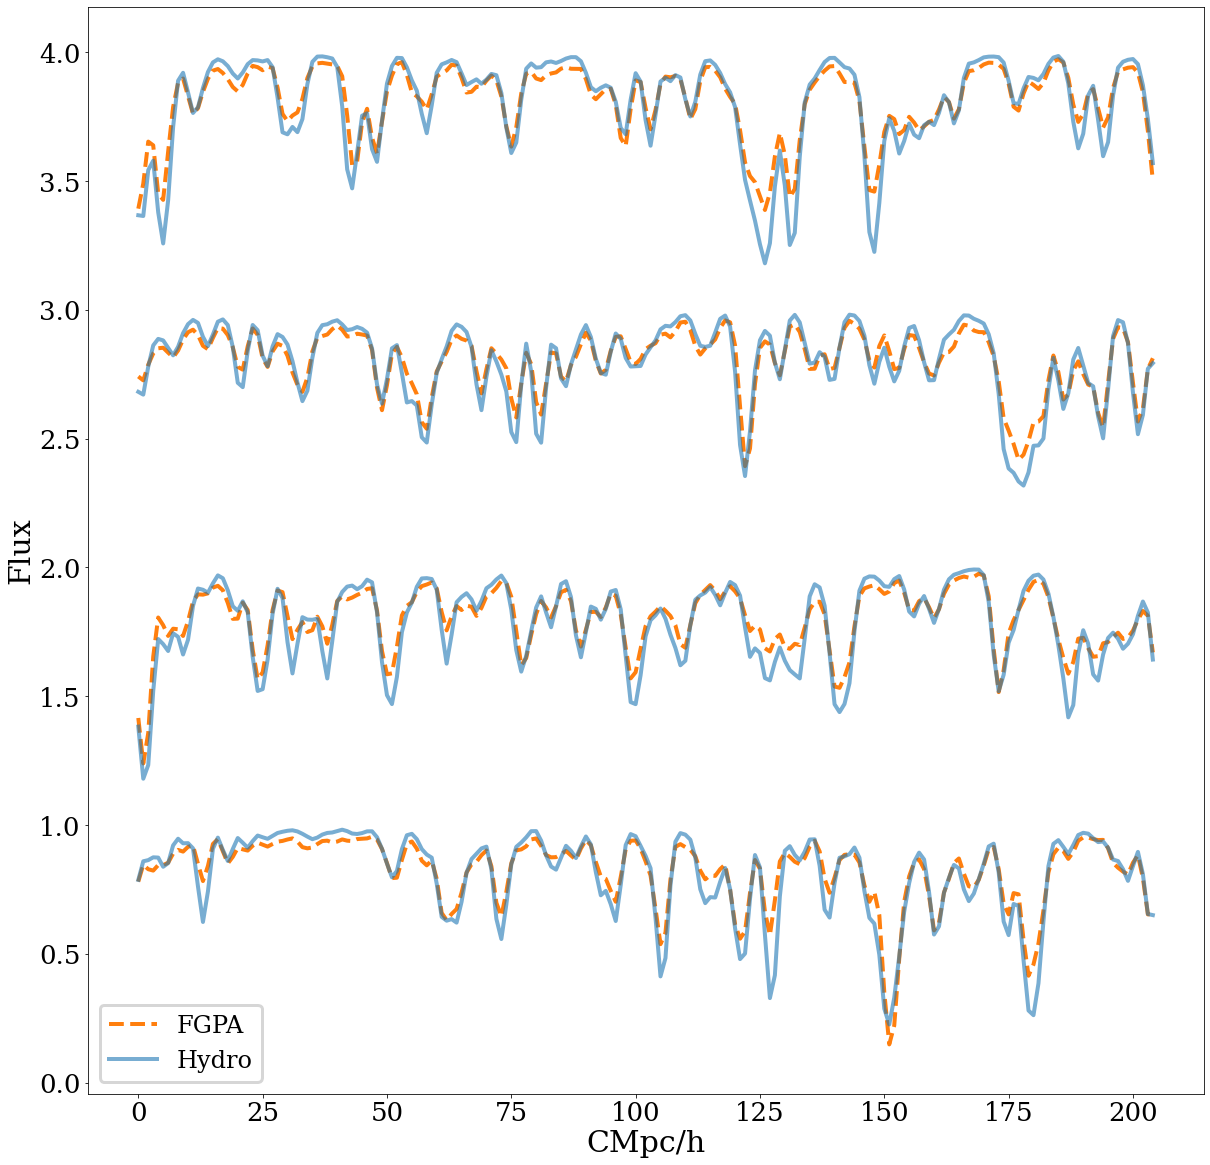

<Figure size 2880x720 with 0 Axes>

In [8]:
def test_full_map(ax):
    plt.figure(figsize=(40,10))
    x, y = [45,10,203, 50], [45,110,82,4] 
    with h5py.File('./FGPA/FGPA_flux_z2.4.hdf5','r') as f:
        with h5py.File('./spectra/maps/map_TNG_true_1.0_z2.4.hdf5','r') as ftrue :
            with h5py.File('./FGPA/FGPA_DMonly_flux_z2.4.hdf5','r') as fDMonly:                
                true_map = gaussian_filter1d(ftrue['flux'][:],1, mode='wrap')
                for i in range(4) :
                    #ax.plot(i+f['map'][x[i],y[i],:], ls='--', label='FGPA on Hydro', color='C0', lw=3)
                    ax.plot(i+fDMonly['map'][x[i],y[i],:], ls='--', label='FGPA', color='C1',lw=4)
                    #print('FGPA :', f['map'][x[i],y[i],0], f['map'][x[i],y[i],-1])
                    #print('Hydro :', true_map[x[i],y[i],0], true_map[x[i],y[i],-1])
                    ax.plot(i+true_map[x[i],y[i],:], label='Hydro', alpha=0.6, color='C0',lw=4)
                    ax.set_ylabel('Flux')
                    if i==0:
                        ax.legend()
        
        ax.set_xlabel('CMpc/h')

fig, ax = plt.subplots(1,1, figsize=(20,20))
test_full_map(ax)
plt.tight_layout()
fig.savefig('Hydro_FGPA_spectra.pdf', transparent=True)

### Run watershed :

In [4]:
def run_watershed():
    import LATIS.codes.minima as minima

    with h5py.File('./FGPA/FGPA_DM_only_flux_z2.4_MF_changed.hdf5','r') as f:
        fgpa_map = f['map'][:]
    with h5py.File('./TNG_DensField/TNG_DM_z2.4.hdf5','r') as f:
        DMconv = gaussian_filter(f['DM/dens'][:],sigma=4,mode='wrap')
    fgpa_map /= np.mean(fgpa_map)
    fgpa_map -= 1
    fgpa_map = gaussian_filter(fgpa_map,4, mode='wrap')
    peaks, lmap = minima.mtomo_partition_v2(fgpa_map, DMconv, thresh=-2.35, linking_contour=2.0)
    
    # Save it :
    with h5py.File('./FGPA/lmap_FGPA_TNG_true_z2.4_MF_changed.hdf5','w') as fw:
        fw['map'] = lmap
    with h5py.File('./FGPA/peaks_FGPA_TNG_true_z2.4_MF_changed.hdf5','w') as fw:
        for a in list(peaks.keys())[0:16]:
            fw[a] = peaks[a]

run_watershed()

Using delta_dm = %0.3f dF**2 %0.4f dF + %0.4f (6.424995055553339, -3.7736627389421646, 0.7764580569349763)
Initially got 174 peaks, 
Periodic BC. Init num of countours:  155
Final Num of countours:  130
paernt  1 Num parts initial : 13 Num parts final: 13
paernt  3 Num parts initial : 3 Num parts final: 3
 contour4 hs no minima within it.
 contour5 hs no minima within it.
 contour6 hs no minima within it.
paernt  8 Num parts initial : 13 Num parts final: 13
 contour9 hs no minima within it.
paernt  10 Num parts initial : 2 Num parts final: 2
paernt  11 Num parts initial : 2 Num parts final: 2
paernt  12 Num parts initial : 7 Num parts final: 7
 contour13 hs no minima within it.
 contour14 hs no minima within it.
 contour15 hs no minima within it.
paernt  16 Num parts initial : 3 Num parts final: 3
 contour17 hs no minima within it.
 contour19 hs no minima within it.
paernt  21 Num parts initial : 2 Num parts final: 2
 contour22 hs no minima within it.
 contour23 hs no minima within it.

### Visualize true  :

I ran `compare_fgpa_hydro.py` and the movie is [here](https://drive.google.com/file/d/1BY75tzA-EPAbA46YRg9qn0IABmzgBaDM/view?usp=sharing) :

### Compare $M_{tomo}$ in true map :

In [4]:
def get_id_max_overlap(lmap1, lmap2):
    """
    returns : A dictionary of the corresponding ids of overlapping structures, just returns those structures which have
    overlapping structures in map2"""
    minima1 = np.unique(lmap1)
    minima2 = np.unique(lmap2)
    minima1 = np.delete(minima1, np.where(minima1==0))
    minima2 = np.delete(minima2, np.where(minima2==0))
    
    
    id_max_overlap = {'map1':np.array([]),'map2':np.array([]), 'no_overlap':np.array([])}
    id_no_overlap = np.array([])

    for i in minima1:
        indm = np.where(lmap1==i)
        ids, counts = np.unique(lmap2[indm], return_counts=True)
        if ids[0] == 0:
            ids = np.delete(ids, 0)
            counts = np.delete(counts, 0)
            if counts.size== 0 :
                id_max_overlap['no_overlap'] =np.append(id_max_overlap['no_overlap'], i)
                continue
        counts_sorted = np.sort(counts)
        # Here, If 2 sub-contours overlap identically, we pick just the one with lower id
        indt = np.where(counts == counts_sorted[-1])[0][0]
        if ids[indt]!=0 :
            id_max_overlap['map1'] = np.append(id_max_overlap['map1'], i)
            id_max_overlap['map2'] = np.append(id_max_overlap['map2'], ids[indt])
            
    
    
    id_max_overlap['map1'].astype(int); id_max_overlap['map2'].astype(int)
    return id_max_overlap

In [5]:
def get_Mtomo_FGPA_hydro(MF_changed = True, savefile='./thresh/FGPA_Hydro_Mtomo_Fig10_data.hdf5', first_hydro=True):
    if MF_changed :
        lmap_fgpa = h5py.File('./FGPA/lmap_FGPA_TNG_true_z2.4_MF_changed.hdf5','r')['map'][:]
    else:
        lmap_fgpa = h5py.File('./FGPA/lmap_FGPA_TNG_true_z2.4.hdf5','r')['map'][:]
    lmap_hydro = h5py.File('./thresh/n1/labeled_map_TNG_true_z2.4_n1_sigma4_th2.35_lc2.00.hdf5','r')['map'][:]
    
    if first_hydro:
        id_max_overlap = get_id_max_overlap(lmap_hydro, lmap_fgpa)
    else:
        id_max_overlap = get_id_max_overlap(lmap_fgpa, lmap_hydro)
    del lmap_hydro, lmap_fgpa
    
    peaks_hydro = h5py.File('./thresh/n1/peaks_TNG_true_z2.4_n1_sigma4_th2.35_lc2.00.hdf5','r')
    if MF_changed:
        peaks_fgpa = h5py.File('./FGPA/peaks_FGPA_TNG_true_z2.4_MF_changed.hdf5','r')
    else :
        peaks_fgpa = h5py.File('./FGPA/peaks_FGPA_TNG_true_z2.4.hdf5','r')
    
    mtomo_hydro = peaks_hydro['mtomo'][:]
    mtomo_fgpa = peaks_fgpa['mtomo'][:]
    if first_hydro :
        mtomo_fgpa_overlap = mtomo_fgpa[id_max_overlap['map2'].astype(int)-1]
        mtomo_hydro_overlap = mtomo_hydro[id_max_overlap['map1'].astype(int)-1]
        signif = peaks_hydro['signif'][:][id_max_overlap['map1'].astype(int)-1]
    else :
        mtomo_fgpa_overlap = mtomo_fgpa[id_max_overlap['map1'].astype(int)-1]
        mtomo_hydro_overlap = mtomo_hydro[id_max_overlap['map2'].astype(int)-1]
        signif = peaks_hydro['signif'][:][id_max_overlap['map2'].astype(int)-1]
    
    if savefile is not None:
        fw = h5py.File(savefile,'w')
        fw['MtomoHydro'] = mtomo_hydro_overlap
        fw['MtomoFGPA'] = mtomo_fgpa_overlap
        fw['Signif'] = signif
    else :
        return mtomo_hydro, mtomo_fgpa, mtomo_hydro_overlap, mtomo_fgpa_overlap, id_max_overlap, signif


In [6]:
def plot_Mtomo_fgpa_hydro(fig, ax, MF_changed = True, first_hydro=True):
    
    _, _ , mtomo_hydro_overlap, mtomo_fgpa_overlap, _, signif = get_Mtomo_FGPA_hydro(MF_changed=MF_changed, savefile=None, first_hydro=True)
    
    ind1 = (signif > -2.5)*(signif < -2.0)
    ind2 = (signif > -3.0)*(signif < -2.5)
    ind3 = (signif > -3.5)*(signif < -3.0)
    ind4 = (signif < -3.5)

    ax.plot([12,16], [12,16], color='k', label='1:1', ls='--', alpha=0.6)

    ax.scatter( mtomo_hydro_overlap[ind1], mtomo_fgpa_overlap[ind1],  alpha=0.7, label=r'$-2.35 < \rm \delta_F / \sigma_{map} < -2.0$', marker= '^', s=100, facecolor="None", edgecolor='C0', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind2], mtomo_fgpa_overlap[ind2],  alpha=0.7, label=r'$-3.0 <  \rm \delta_F / \sigma_{map} < -2.5$', marker= 's', s=100, facecolor='None', edgecolor='C1', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind3], mtomo_fgpa_overlap[ind3],  alpha=0.7, label=r'$-3.5 <  \rm \delta_F / \sigma_{map} < -3.0$', marker = 'o', s=100, facecolor='None', edgecolor='C2', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind4], mtomo_fgpa_overlap[ind4], alpha=0.7, label=r'$ \  \rm \delta_F / \sigma_{map} < -3.5 $', marker ='D', s=100, facecolor='None', edgecolor='C3', linewidth=2)


    ax.set_xlabel(r'$\mathrm{log [ M_{tomo} (Hydro) ]}$')
    ax.set_ylabel(r'$\mathrm{log [ M_{tomo} (FGPA) ]}$')
    ax.set_xlim(13.0,15.5)
    ax.legend(framealpha=0, fontsize=18)

    ax.set_ylim(13,15.5)
    ax.grid(True, alpha=0.6)
    plt.setp(ax.get_xticklabels(), rotation=40)

def get_erros_Mtomo_fgpa(MF_changed=True, bins = np.append(np.array([13.5]), np.arange(14,15.5,0.25))):
    """A method to get the statistics on FGPa-Hydro Mtomo comparision"""
    
    from astropy.stats import sigma_clip
    from astropy.stats import sigma_clipped_stats
    outlier_frac, median, std = [], [], []
    mbins = []
    mtomo_hydro, _ , mtomo_hydro_overlap, mtomo_fgpa_overlap, id_max_overlap, _ =  get_Mtomo_FGPA_hydro(MF_changed=MF_changed, savefile=None)
    def cenfunc(data, axis=None):
        return 0
    for i, b in enumerate(np.arange(bins.size-1)):
        ind_all = np.where((mtomo_hydro < bins[b+1])*(mtomo_hydro > bins[b]))[0]
        mbins.append((bins[b+1]+bins[b])/2)
        ind = np.isin(id_max_overlap['map1'], ind_all+1)
        
        #outliers = sigma_clip(mtomo_fgpa_overlap[ind]- mtomo_hydro_overlap[ind], sigma=3, maxiters=None, 
        #                      cenfunc=cenfunc, masked=True, copy=False).mask
        # To find outliers, we look for strucutres with a deviation in measurement larger than 3 times of
        # our error in Mtomo-MDM realtion
        dev = mtomo_fgpa_overlap[ind] - mtomo_hydro_overlap[ind]
        std_mtomo = np.array([0.36, 0.33, 0.29])
        not_outlier = np.where(np.abs(dev) < 3*std_mtomo[i])[0]
        outlier_frac.append(1 - not_outlier.size / ind_all.size)
        _, MedianSigClip, StdSigClip = sigma_clipped_stats(dev, sigma=3, maxiters=None, 
                                                           cenfunc=cenfunc)
        median.append(MedianSigClip)
        std.append(StdSigClip)

    return median, std, outlier_frac

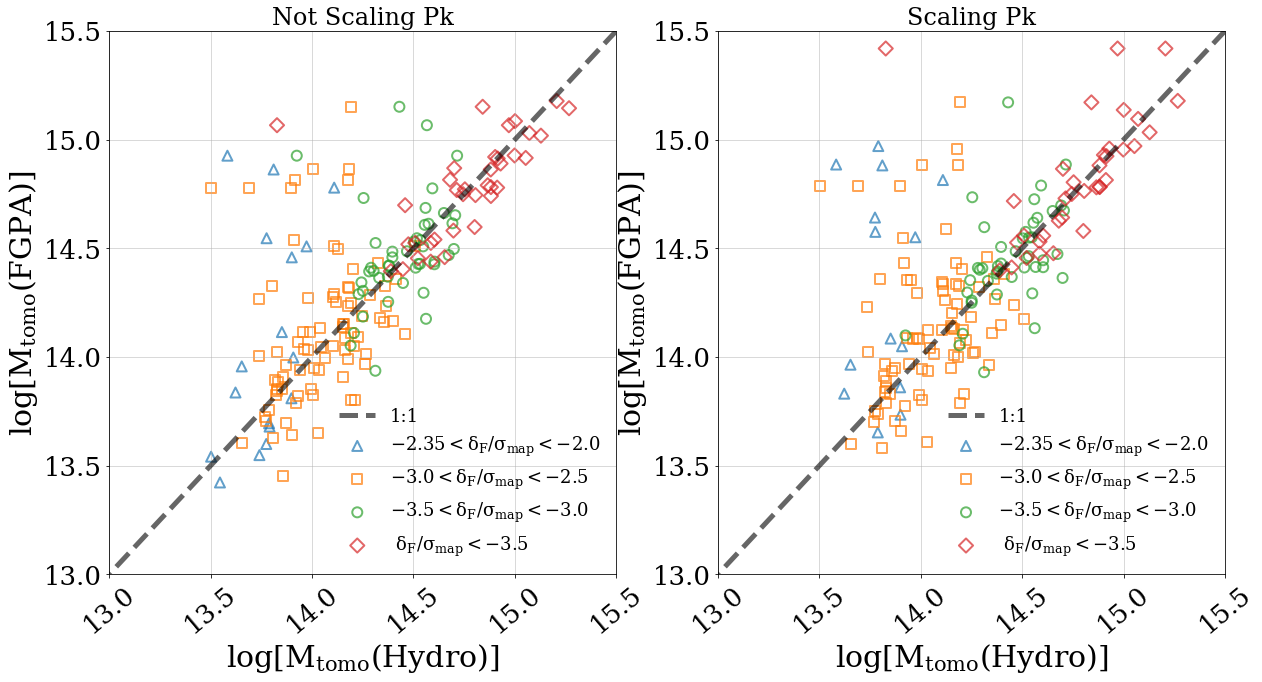

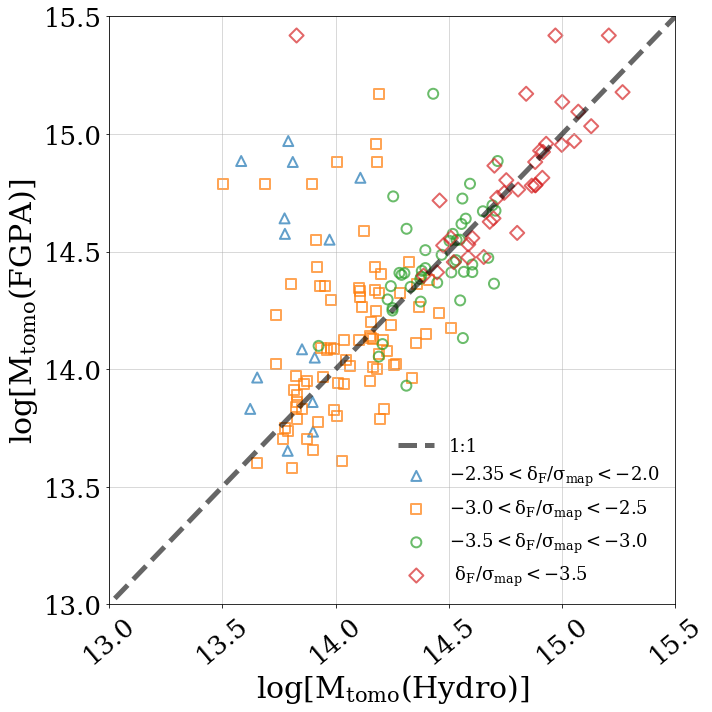

In [174]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

plot_Mtomo_fgpa_hydro(fig=fig, ax=ax[0], MF_changed=False)
ax[0].set_title('Not Scaling Pk')

fig_new, ax_new = plt.subplots(1,1,figsize=(10,10))
for f, a in [(fig,ax[1]), (fig_new, ax_new)]:
    plot_Mtomo_fgpa_hydro(fig=f, ax=a, MF_changed=True)
    

ax[1].set_title('Scaling Pk')
plt.tight_layout()
#fig_new.savefig('FGPA_hydro_Mtomo_pk_scaled.pdf')


The fraction of fake waterhseds in FGPA : 0.1206896551724138


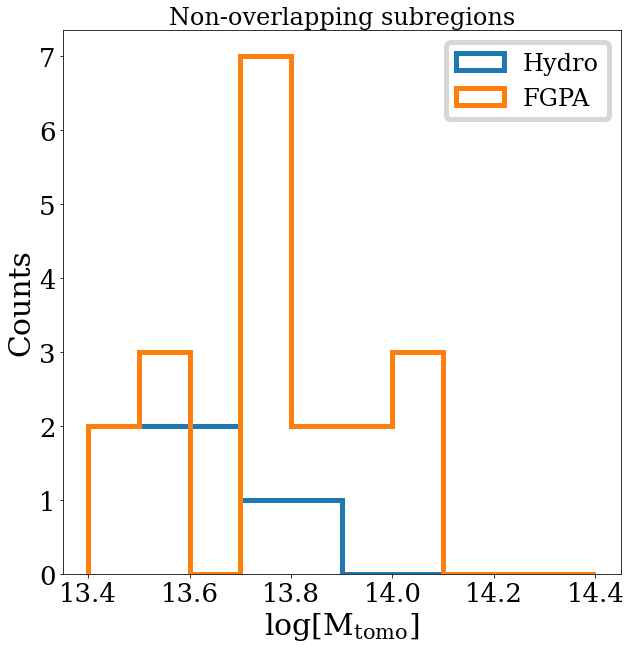

In [100]:
def mass_nonoverlapping_subregions():
    """"""
    mtomo_hydro, mtomo_fgpa , _, _, id_no_overlap , _ = get_Mtomo_FGPA_hydro(MF_changed=True, savefile=None)
    bins = np.arange(13.4, 14.5, 0.1)
    plt.hist(mtomo_hydro[id_no_overlap['hydro']-1], histtype='step', bins=bins, label='Hydro')
    plt.hist(mtomo_fgpa[id_no_overlap['fgpa']-1], histtype='step', bins=bins, label='FGPA')
    plt.title('Non-overlapping subregions')
    plt.xlabel(r'$\mathrm{log [ M_{tomo}]}$')
    plt.ylabel('Counts')
    print('The fraction of fake waterhseds in FGPA :', id_no_overlap['fgpa'].size / mtomo_fgpa.size)
    plt.legend()
mass_nonoverlapping_subregions()  


The hist above shows how FGPA merges strucutres and forms massive (~ 14 ) watersheds.

The erros in FGPA :

Before changing the mean

In [102]:
id_no_overlap, median, std, outlier_frac = get_erros_Mtomo_fgpa(MF_changed=False, bins=np.array([13.5,14,14.5,15.5]))
print('IN mass bins Median', median ,  'RMS = : ', std, 'Outlier fraction (not overlapping or an error larger than 3*std) = ', outlier_frac)

IN mass bins Median [0.030296782244159992, -0.005717628364784844, -0.047650502805550055] RMS = :  [0.2296990887875058, 0.17931652393200148, 0.11469237552257976] Outlier fraction (not overlapping or an error larger than 3*std) =  [0.10909090909090913, 0.0, 0.0]


Before changing the mean fkux :

The errors afer fixing the mean flux in FGPA to match the power spectrum with Hydro :

In [101]:
id_no_overlap, median, std, outlier_frac = get_erros_Mtomo_fgpa(MF_changed=True, bins=np.array([13.5,14,14.5,15.5]))
print('IN mass bins Median', median ,  'RMS = : ', std, 'Outlier fraction (not overlapping or an error larger than 3*std) = ', outlier_frac)

IN mass bins Median [0.08548016482743126, -0.0004846929542150491, -0.04315602155468756] RMS = :  [0.2301340991877643, 0.18653567736930768, 0.15293955898117167] Outlier fraction (not overlapping or an error larger than 3*std) =  [0.19999999999999996, 0.0, 0.0]


It is interesting that we got slightly larger erros and outlier fractions after fixing the scale of the power spectrum. 

- The quality of FGPA is worse for low mas sstructures. From this figure and [this movie](https://drive.google.com/file/d/1BY75tzA-EPAbA46YRg9qn0IABmzgBaDM/view?usp=sharing) (lime color idicates the outliers within old defenition, error larger 0.4 dex or no overlapping at all), we can tell FGPA is merging some strucutres since it does not capture all minima wuthin the map. 



In [9]:
with h5py.File('./thresh/n1/peaks_TNG_true_z2.4_n1_sigma4_th2.30.hdf5','r') as peaks_hydro:
    with h5py.File('./FGPA/peaks_FGPA_TNG_true_z2.4.hdf5','r') as peaks :
        print(id_no_overlap['fgpa'].size / peaks['x'].size)
        print(id_no_overlap['hydro'].size / peaks_hydro['x'].size)

0.11351351351351352
0.1065989847715736


Write down the id of the outliers to indicate on map :

### Gaussian KDE :

It helps to find the mass cut where FGPa fails :

In [11]:
def kde_Mtomo_fgpa_hydro(fig, ax, MF_changed = True, first_hydro=True, legend=True, title=''):
    from scipy.stats import gaussian_kde as gkde
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    _, _ , mtomo_hydro_overlap, mtomo_fgpa_overlap, _, signif = get_Mtomo_FGPA_hydro(MF_changed=MF_changed, savefile=None, first_hydro=first_hydro)
    
    data = np.zeros((2,mtomo_hydro_overlap.size))
    data[0,:] = mtomo_hydro_overlap
    data[1,:] = mtomo_fgpa_overlap
    
    kernel = gkde(data)  
    
    X, Y = np.mgrid[13.2:15.5:50j, 13.2:15.5:50j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    fig2,ax2 = plt.subplots(1,1)
    ax2.hist(Z.ravel())
    im = ax.imshow(np.rot90(Z), cmap=plt.cm.viridis, extent = [13, 16, 13, 16], vmin=0, vmax=1.8)
    if legend:
        axins = inset_axes(ax,width="100%", height="100%",  bbox_to_anchor=(1.1,0.4, 0.6, 0.05), bbox_transform=ax.transAxes)
        cb = fig.colorbar(im, cax=axins, orientation='horizontal')
        cb.ax.set_xlabel('Gaussian KDE', labelpad=30)
        cb.set_ticks([0,0.9,1.8])
    
    
    ind1 = (signif > -2.5)*(signif < -2.0)
    ind2 = (signif > -3.0)*(signif < -2.5)
    ind3 = (signif > -3.5)*(signif < -3.0)
    ind4 = (signif < -3.5)

    ax.plot([12,16], [12,16], color='k', label='1:1', ls='--', alpha=0.4)

    ax.scatter( mtomo_hydro_overlap[ind1], mtomo_fgpa_overlap[ind1],  alpha=0.7, label=r'$-2.35 < \rm \delta_F / \sigma_{map} < -2.0$', marker= '^', s=50, facecolor="None", edgecolor='r', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind2], mtomo_fgpa_overlap[ind2],  alpha=0.7, label=r'$-3.0 <  \rm \delta_F / \sigma_{map} < -2.5$', marker= 's', s=50, facecolor='None', edgecolor='C1', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind3], mtomo_fgpa_overlap[ind3],  alpha=0.7, label=r'$-3.5 <  \rm \delta_F / \sigma_{map} < -3.0$', marker = 'o', s=50, facecolor='None', edgecolor='b', linewidth=2)
    ax.scatter( mtomo_hydro_overlap[ind4], mtomo_fgpa_overlap[ind4], alpha=0.7, label=r'$ \  \rm \delta_F / \sigma_{map} < -3.5 $', marker ='D', s=50, facecolor='None', edgecolor='w', linewidth=2)


    ax.set_xlabel(r'$\mathrm{log [ M_{tomo} (Hydro) ]}$')
    ax.set_ylabel(r'$\mathrm{log [ M_{tomo} (FGPA) ]}$')
    ax.set_title(title, pad=30)
    
    ax.set_xlim([13, 16])
    ax.set_ylim([13, 16])
    ax.set_xticks([13.5,14,14.5,15,15.5])
    ax.set_yticks([13.5,14,14.5,15,15.5])
    #ax.set_yticks([50,150,300])
    if legend:
        ax.legend(framealpha=0.7, fontsize=18, loc=(1.005, 0.5), facecolor='gray')
    
    ax.grid(True, alpha=0.6)
    plt.setp(ax.get_xticklabels(), rotation=40)

<ipython-input-12-3360fc1a5eb3>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


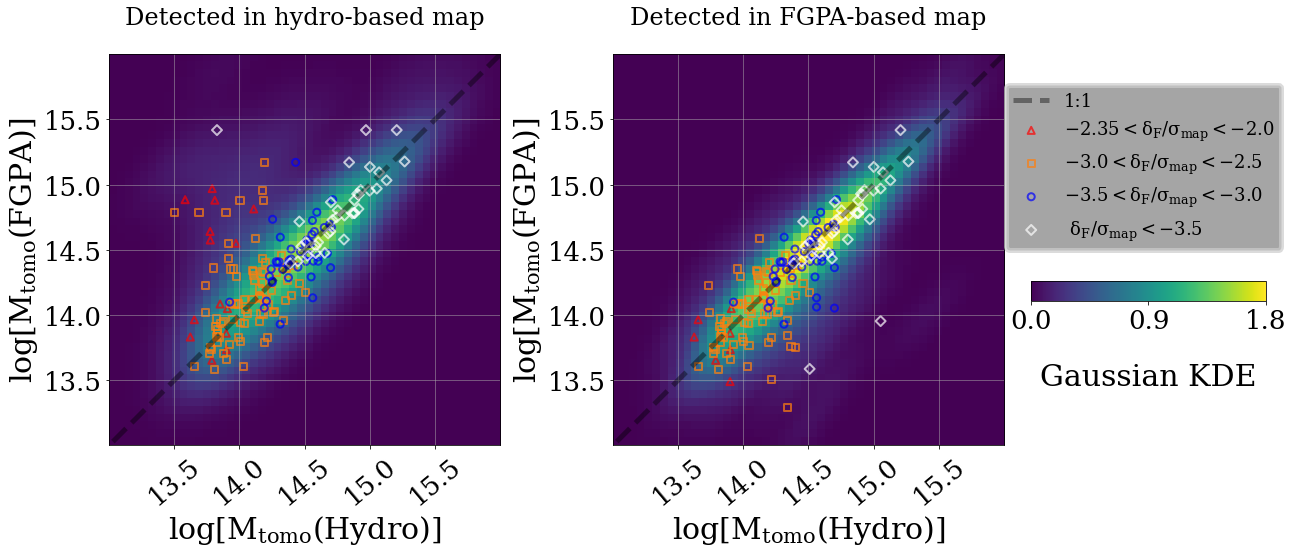

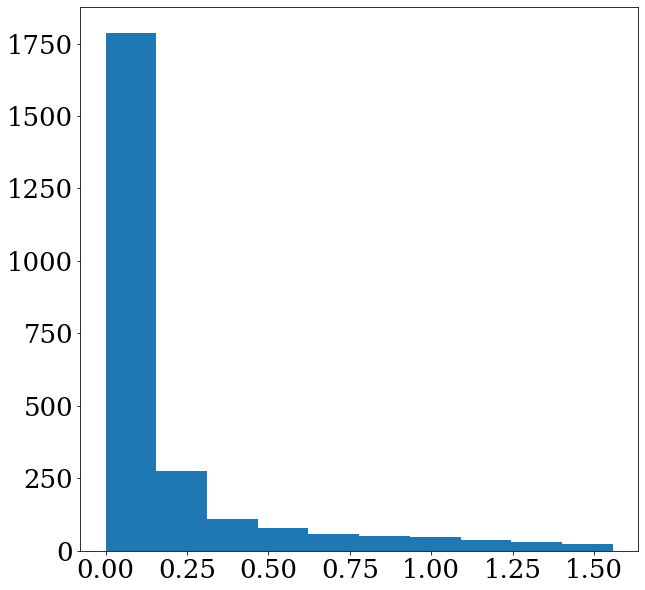

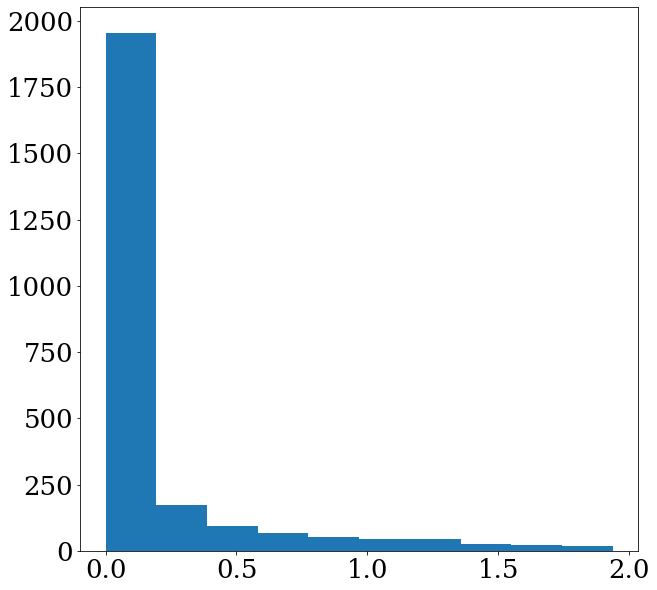

In [12]:
fig, ax = plt.subplots(1,2, figsize=(18,9))
kde_Mtomo_fgpa_hydro(fig, ax[0], first_hydro=True, legend=False, title='Detected in hydro-based map')
kde_Mtomo_fgpa_hydro(fig, ax[1], first_hydro=False, title='Detected in FGPA-based map')
fig.tight_layout()
fig.savefig('FGPA_hydro_Mtomo_kde.pdf')

### Characterizing the overmerging in FGPA :

In [16]:
def get_number_of_overmerged_watersheds():
    
    
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    
    
    for first_hydro in [True, False]:
        mtomo_hydro, mtomo_fgpa , mtomo_hydro_overlap, mtomo_fgpa_overlap, id_max_overlap, signif = get_Mtomo_FGPA_hydro(MF_changed=True, 
                                                                                                                               savefile=None,first_hydro=first_hydro)        
        _, unique_indices, counts = np.unique(id_max_overlap['map2'][:], return_counts=True, return_index=True)
        indices_merged = unique_indices[counts!=1]
            
        if first_hydro:
            print('Number of blended watershesd in Hydro (Fraction) = ', np.sum(counts[counts!=1]), np.sum(counts[counts!=1])/mtomo_hydro.size )
            label='blended'
            ls='solid'
        else:
            print('Number of deblended watersheds in Hydro (Fraction) = ', indices_merged.size, indices_merged.size/mtomo_hydro.size)
            label='deblended'
            ls='--'
        
        ax[0].hist(np.unique(mtomo_hydro_overlap[indices_merged.astype(int)]), bins=np.arange(12.75,16.5,0.25), histtype='step', label=label, ls=ls)

        if first_hydro:
            print('Number of watersheds have no overlap in Hydro', id_max_overlap['no_overlap'][:].size, id_max_overlap['no_overlap'].size/mtomo_hydro.size)
            ax[1].hist(mtomo_hydro[id_max_overlap['no_overlap'][:].astype(int)-1], bins=np.arange(12.75,16.5,0.5), histtype='step', label='Hydro')
        else:
            print('Number of watersheds have no overlap in FGPA', id_max_overlap['no_overlap'][:].size, id_max_overlap['no_overlap'].size/mtomo_fgpa.size)
            ax[1].hist(mtomo_fgpa[id_max_overlap['no_overlap'][:].astype(int)-1], bins=np.arange(12.75,16.5,0.5), histtype='step', label='FGPA', ls='--')
    
    ax[0].set_xlabel(r'$\rm M_{tomo, Hydro}$')
    ax[0].set_ylabel('Count')
    ax[1].set_xlabel(r'$\rm M_{tomo}$')
    ax[1].set_ylabel('Count')
    ax[1].set_title('no overlap')
    ax[0].legend(loc='upper left', framealpha=0)
    ax[1].legend()
    ax[1].set_ylim((0,8))
    ax[0].set_xticks(np.arange(13, 16, 0.5))
    ax[0].grid(True)
    ax[1].grid(True)

Number of blended watershesd in Hydro (Fraction) =  40 0.21739130434782608
Number of watersheds have no overlap in Hydro 8 0.043478260869565216
Number of deblended watersheds in Hydro (Fraction) =  12 0.06521739130434782
Number of watersheds have no overlap in FGPA 9 0.05172413793103448


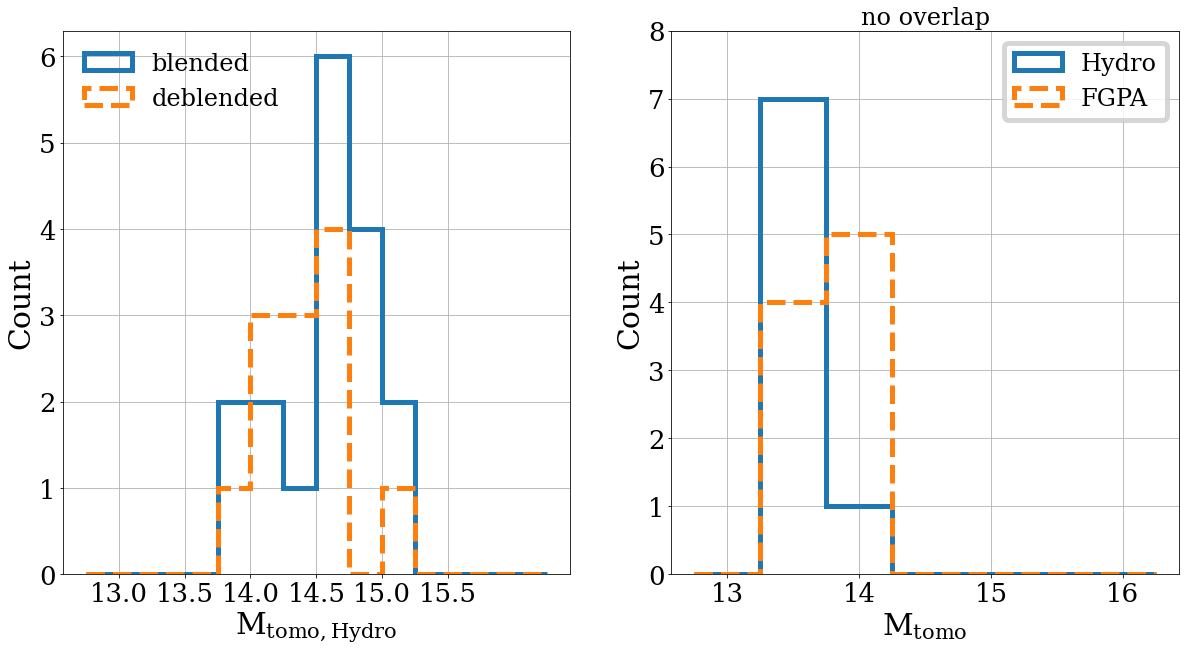

In [17]:
get_number_of_overmerged_watersheds()

So :

- It is more likely FGPA merges watersheds than breaking watersheds into smaller pieces. 

- The watersheds belnded by FGPA are slightly more massvie than those deblended by FGPA.

- The watersheds FGPA fakely produces are slightly more massive than watersheds in Hydro which FGPA missed to indentify.
